In [212]:
# Import Libraries
from PIL import Image
import cv2
from plantcv import plantcv as pcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [213]:
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

In [214]:
class options:
    def __init__(self):
        self.image = "Still-1-Camera_Name-2021-06-13_11-27-57.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "vis_nir_test_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

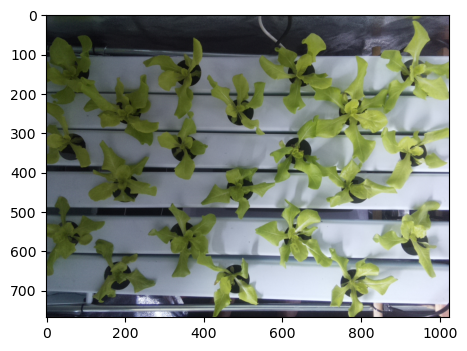

In [215]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)

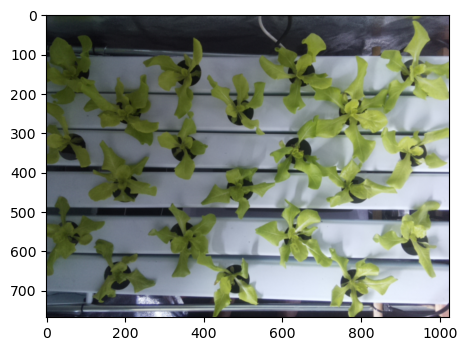

In [216]:
# Apply gaussian blur to a binary image that has been previously thresholded.
#gaussian_img = pcv.gaussian_blur(img=img, ksize=(3, 3), sigma_x=0, sigma_y=None)


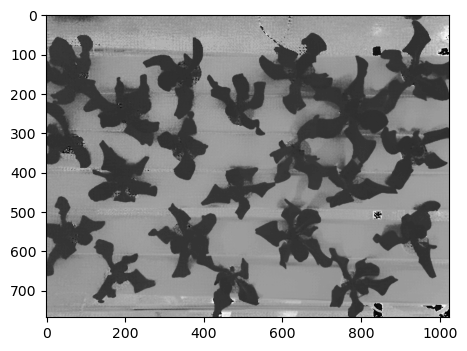

In [225]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_img - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='h')

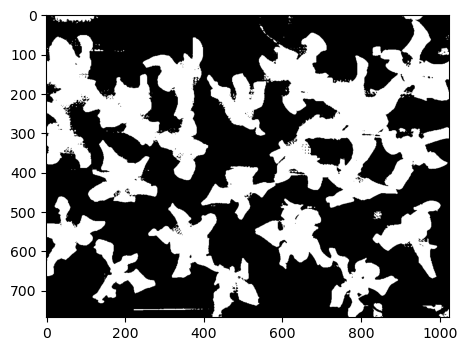

In [226]:
# Create binary image from a gray image based on threshold values. 
# Targeting dark objects in the image.
threshold_dark = pcv.threshold.otsu(gray_img=s, max_value=255, object_type='dark')


In [227]:
#mask, masked_img = pcv.threshold.custom_range(img=img, lower_thresh=[10,10,10], upper_thresh=[100,255,100], channel='HSV')

In [228]:
# Create masked image from a color image based HSV color-space and threshold values. 
# for lower and upper_thresh list as: thresh = [hue_thresh, saturation_thresh, value_thresh]

#mask, masked_img = pcv.threshold.custom_range(img=img, lower_thresh=[30,65,20], upper_thresh=[80,255,220], channel='RGB')


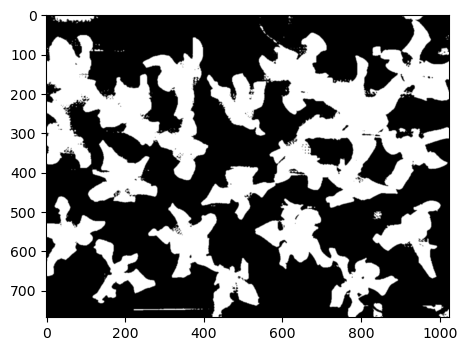

In [229]:
# Apply gaussian blur to a binary image that has been previously thresholded.
#gaussian_img = pcv.gaussian_blur(img=threshold_dark, ksize=(3, 3), sigma_x=0, sigma_y=None)


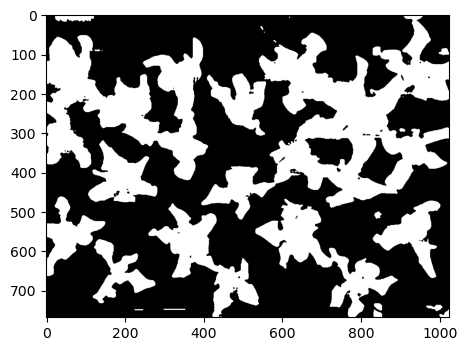

In [232]:
binary_img = pcv.median_blur(gray_img=threshold_dark, ksize=5)

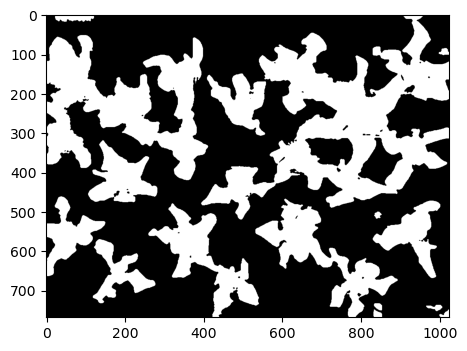

In [233]:
fill_image = pcv.fill(bin_img=binary_img, size=200)

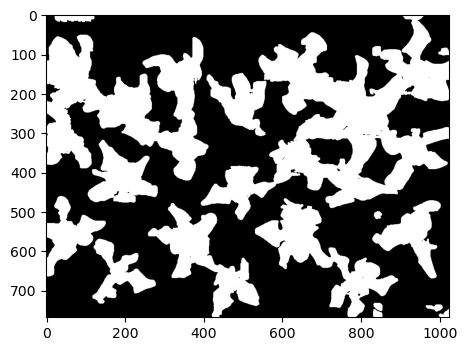

In [234]:
# Perform dilation
# Results in addition of pixels to the boundary of object
dilate_img = pcv.dilate(gray_img=fill_image, ksize=3, i=1)

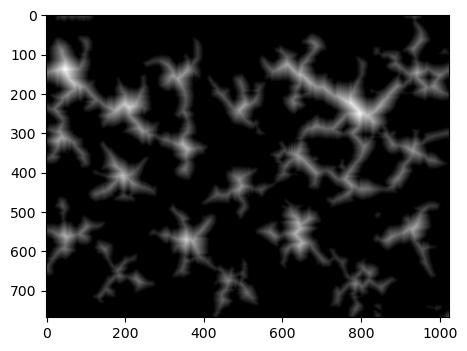

In [235]:
# Perform dilation
# Results in addition of pixels to the boundary of object
distance_transform_img = pcv.distance_transform(bin_img=dilate_img, distance_type=1, mask_size=3)


In [236]:
# Finding sure foreground area
ret, sure_fg = cv2.threshold(distance_transform_img,0.7*distance_transform_img.max(),255,0)

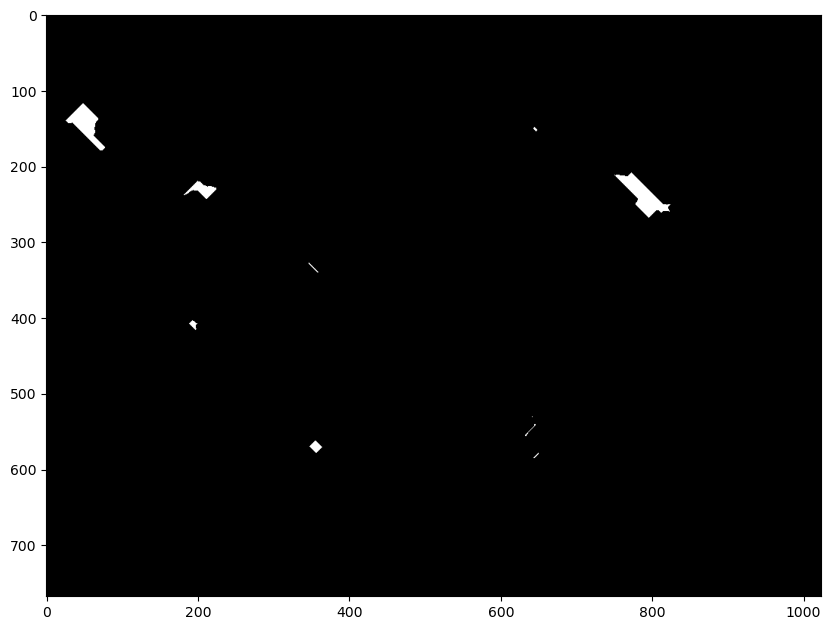

In [237]:
display(sure_fg,cmap='gray')

In [238]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(dilate_img,sure_fg)

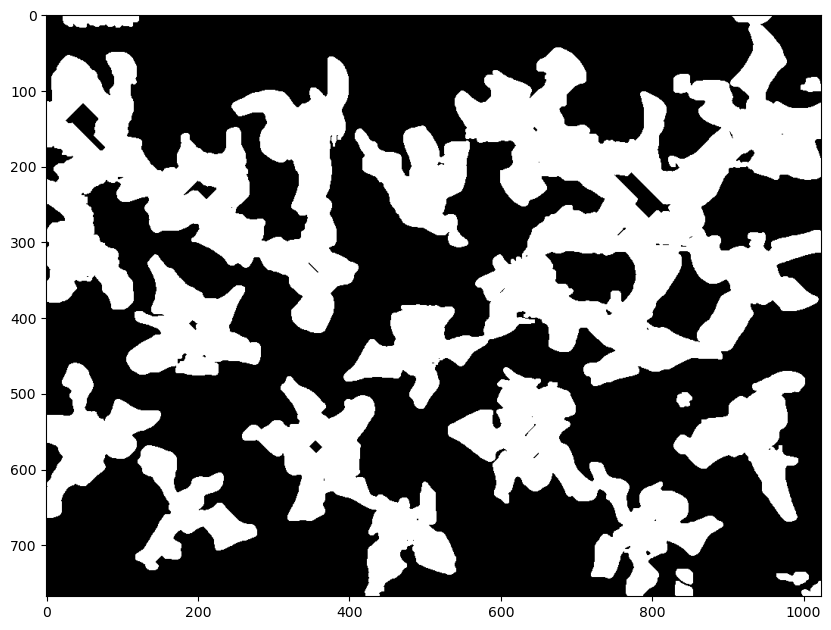

In [239]:
display(unknown,cmap='gray')

In [240]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

In [241]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

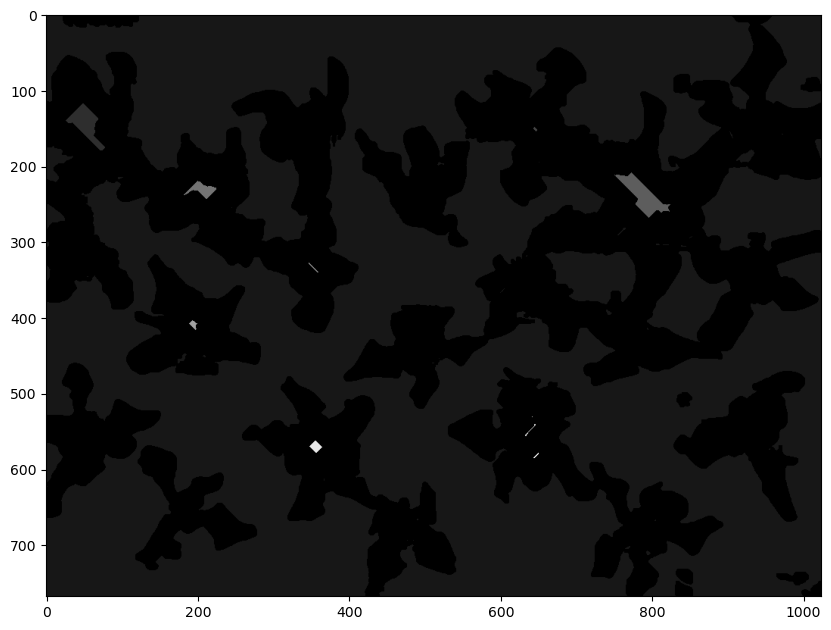

In [242]:
display(markers,cmap='gray')

In [243]:
markers = cv2.watershed(img,markers)

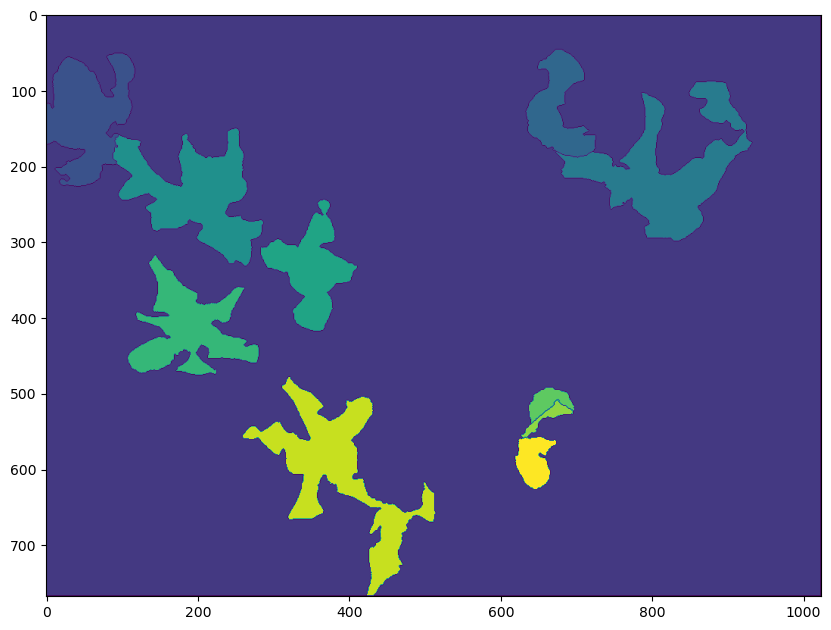

In [244]:
display(markers)

In [245]:
image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

# For every entry in contours
for i in range(len(contours)):
    
    # last column in the array is -1 if an external contour (no contours inside of it)
    if hierarchy[0][i][3] == -1:
        
        # We can now draw the external contours from the list of contours
        cv2.drawContours(img, contours, i, (255, 0, 0), 10)

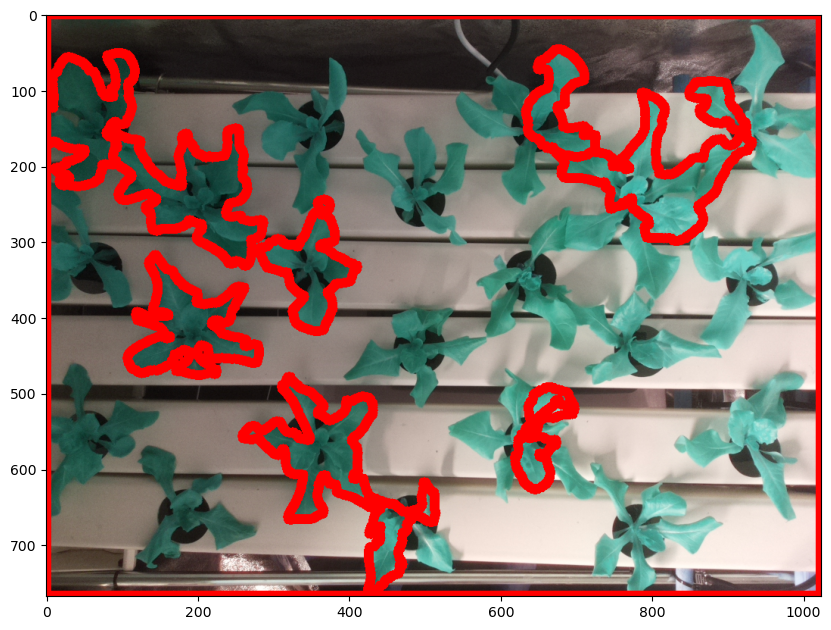

In [246]:
display(img)